In [ ]:
import sys
import os
from pathlib import Path
sub_project_dir = Path(os.path.abspath(''))
project_dir = sub_project_dir.parent
sys.path.insert(0, project_dir.parent.as_posix())

import datasets
import numpy as np
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
import timm
import timm
from transformers import AutoImageProcessor, ViTModel
from torchvision import transforms

mpl.rcParams.update({'font.size': 11, 'axes.titlesize': 11, 'axes.labelsize': 11})

%load_ext autoreload
%autoreload 2
from llm_papers.vit.dataset import CIFARDataset
from llm_papers.vit.model import ViT

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
# model = ViT(
#     img_size=224,
#     patch_size=32,
#     num_classes=100,
#     d_model=768,
#     d_mlp=3072,
#     num_layers=12,
#     num_heads=12,
# ).eval()
# model_timm = timm.create_model("vit_base_patch32_224", pretrained=True, num_classes=model.num_classes)
# image_processor = AutoImageProcessor.from_pretrained(model_timm.default_cfg['hf_hub_id'])
# model.load_timm(model_timm.state_dict())
model = ViTModel.from_pretrained('google/vit-base-patch32-224-in21k')

### 1. Attention Rollout

In [7]:
dataset = datasets.load_dataset("uoft-cs/cifar100")
test_dataset = CIFARDataset(dataset["test"], image_processor)

In [44]:
batch_size = 16
raw_images = [dataset["test"][i]["img"] for i in range(batch_size)]
images = [test_dataset[i]["images"][None] for i in range(batch_size)]
images = torch.cat(images, dim=0)

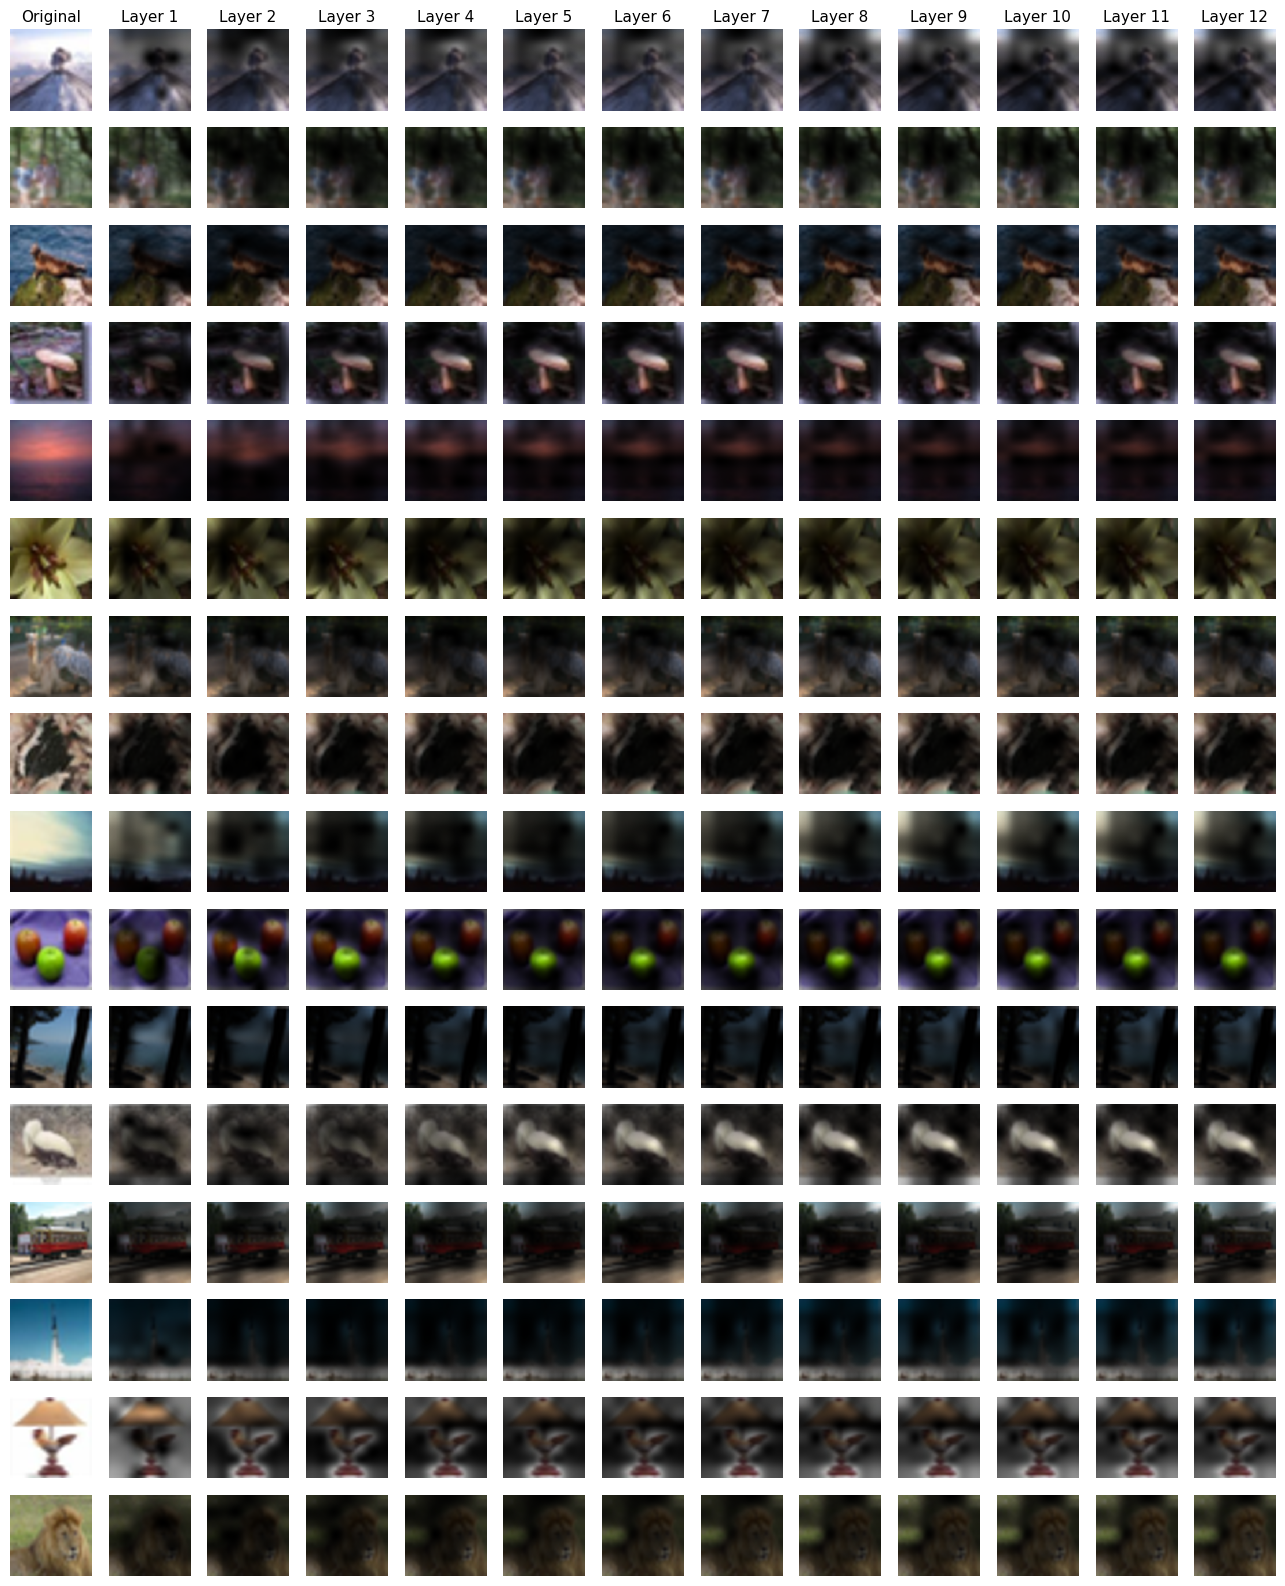

In [99]:
@torch.inference_mode()
def attention_rollout(model, residual=True):
    if isinstance(model, ViTModel):
        model.set_attn_implementation("eager")
        result = model(images, output_attentions=True)
        attentions = torch.stack(result.attentions)  # (num_layers, B, H, L, L)
    else:
        attentions = model(images, output_attentions=True)  # (num_layers, B, H, L, L)
    attentions = attentions.mean(2)  # (num_layers, B, L, L)
    attentions = attentions.swapaxes(0, 1)  # (B, num_layers, L, L)
    if residual:
        attentions = 0.5 * (attentions + torch.eye(attentions.size(-1)))
    masks = []
    for i in range(attentions.size(1)):
        Al = attentions[:, i]  # (B, L, L)
        if i == 0:
            R = Al
        else:
            R = Al @ R
        mask = R[:, 0, 1:]  # (B, num_patches)
        masks.append(mask)
    masks = torch.stack(masks, dim=1)  # (B, num_layers, num_patches)
    num_patch_side = int(masks.shape[-1] ** 0.5)
    B, num_layers = masks.shape[:2]
    masks = masks.view(B, num_layers, num_patch_side, num_patch_side)
    transform = transforms.Resize(
        [224, 224], interpolation=transforms.InterpolationMode.BICUBIC
    )
    masks = transform(masks).cpu().numpy()  # (B, num_layers, h, w)
    fig, axes = plt.subplots(B, num_layers + 1, figsize=(num_layers + 1, B))
    for i in range(B):
        original_image = np.asarray(transform(raw_images[i])) / 255.0
        mask = masks[i][..., None]  # (num_layers, h, w, 1)
        for k in range(len(mask)):
            mask[k] = (mask[k] - mask[k].min()) / (mask[k].max() - mask[k].min())
        axes[i, 0].imshow(original_image, interpolation="none")
        axes[i, 0].axis("off")
        for j in range(num_layers):
            alpha = 1 - mask[j]  # (h, w, 1)
            _mask = np.concat([np.zeros_like(original_image), alpha], axis=-1)
            axes[i, j + 1].imshow(original_image, interpolation="none")
            axes[i, j + 1].imshow(_mask, interpolation="none")
            axes[i, j + 1].axis("off")
            if i == 0:
                axes[i, j + 1].set_title(f"Layer {j+1}")
    axes[0, 0].set_title("Original")
    plt.tight_layout()
    plt.show()


attention_rollout(model, residual=True)
# attention_rollout(model, residual=False)

### 2. Patch Embedding PCA

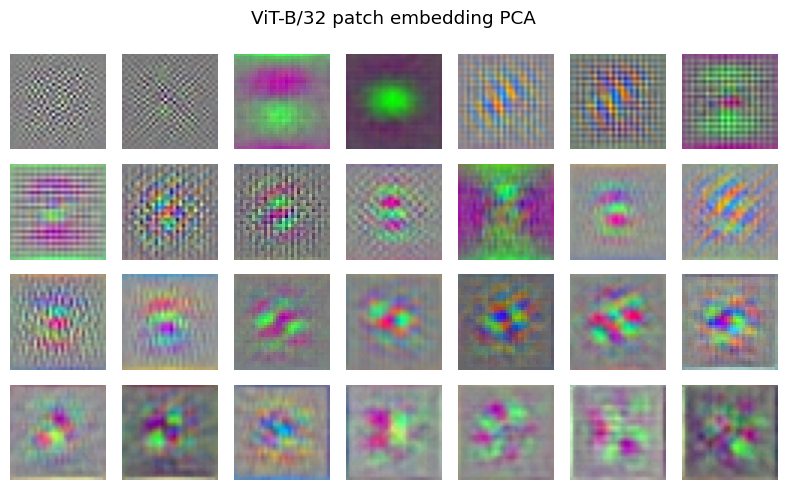

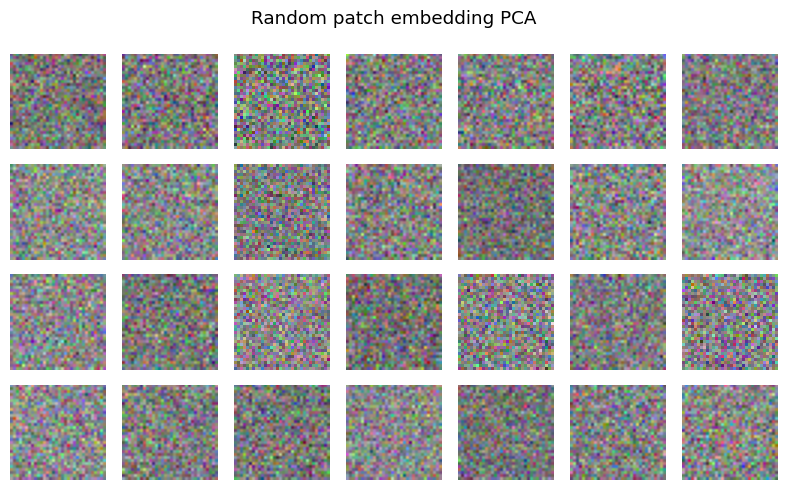

In [82]:
@torch.inference_mode()
def pca(patch_emb_weight, topk=28, title=None):
    Cout, Cin, H, W = patch_emb_weight.shape

    X = patch_emb_weight.reshape(Cout, Cin * H * W)
    mean = X.mean(dim=0, keepdim=True)
    X_centered = X - mean

    # U: (Cout, Cout)，S: (Cout,)，V: (Cin*H*W, Cout)
    U, S, V = torch.svd(X_centered)

    principal_components = V[:, :topk].T

    fig, axes = plt.subplots(4, 7, figsize=(8, 5))
    axes = axes.flatten()

    for i, pc in enumerate(principal_components):
        pc_image = pc.reshape(Cin, H, W).detach().cpu().numpy()
        pc_image = (pc_image - pc_image.min()) / (pc_image.max() - pc_image.min())
        pc_image = pc_image.transpose(1, 2, 0)
        axes[i].imshow(pc_image)
        axes[i].axis("off")

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()


pca(model.patch_embed.proj.weight, title="ViT-B/32 patch embedding PCA")
pca(torch.randn_like(model.patch_embed.proj.weight), title="Random patch embedding PCA")

### 3. Position Embedding Similarity

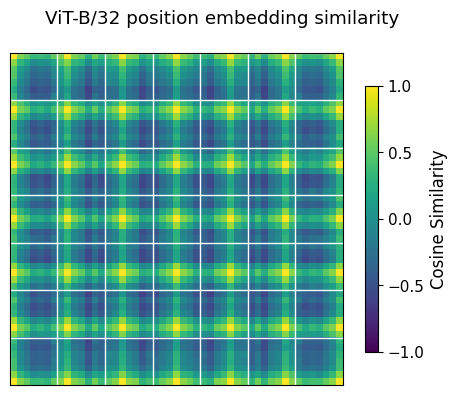

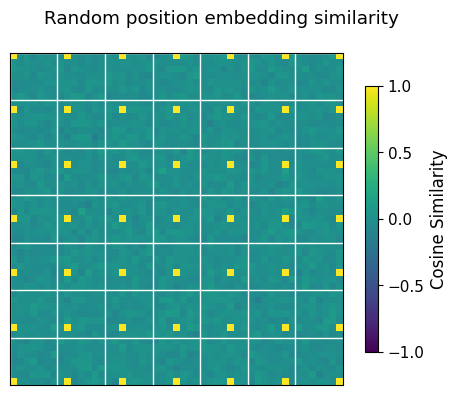

In [84]:
from sklearn.metrics.pairwise import cosine_similarity


def reorder_similarity_matrix(similarity_matrix):
    """
    Reorders a d^2×d^2 patch similarity matrix into a nested grid structure:
    - Outer grid: d×d big grids (each corresponds to a source patch's spatial position)
    - Inner grid: d×d small grids (each corresponds to the similarity between source patch and target patch)

    Args:
        similarity_matrix (np.ndarray): Original similarity matrix

    Returns:
        reordered_similarity_matrix
    """
    d = int(np.sqrt(similarity_matrix.shape[0]))
    reordered_similarity_matrix = np.zeros_like(similarity_matrix)
    for source_index, sims in enumerate(similarity_matrix):
        source_row = source_index // d
        source_col = source_index % d
        for target_index, sim in enumerate(sims):
            target_row = target_index // d
            target_col = target_index % d

            new_row = source_row * d + target_row
            new_col = source_col * d + target_col

            reordered_similarity_matrix[new_row, new_col] = sim

    return reordered_similarity_matrix


@torch.inference_mode()
def position_embedding_similarity(pos_emb, title=None):
    pos_emb = pos_emb[1:]  # (num_patches, d_model)
    num_patches, D = pos_emb.shape
    num_patches_per_side = int(np.sqrt(num_patches))

    similarity_matrix = cosine_similarity(pos_emb)  # (num_patches, num_patches)
    similarity_matrix = reorder_similarity_matrix(similarity_matrix)

    plt.figure(figsize=(5, 4))
    im = plt.imshow(similarity_matrix, cmap="viridis", vmin=-1, vmax=1)

    for i in range(num_patches_per_side):
        plt.axvline(x=i * num_patches_per_side - 0.5, color="white", linewidth=1)
        plt.axhline(y=i * num_patches_per_side - 0.5, color="white", linewidth=1)

    plt.xticks([])
    plt.yticks([])

    cbar = plt.colorbar(im, shrink=0.8)
    cbar.set_label("Cosine Similarity", fontsize=12)
    cbar.set_ticks([-1, -0.5, 0, 0.5, 1])

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()


position_embedding_similarity(
    model.pos_embed[0], title="ViT-B/32 position embedding similarity"
)
position_embedding_similarity(
    torch.randn_like(model.pos_embed[0]), title="Random position embedding similarity"
)